Epoch 1: 100%|██████████| 498/498 [03:38<00:00,  2.27it/s]


E1: train DICE 0.6596 | val DICE 0.7162


Epoch 2: 100%|██████████| 498/498 [03:40<00:00,  2.26it/s]


E2: train DICE 0.7341 | val DICE 0.7779


Epoch 3: 100%|██████████| 498/498 [03:41<00:00,  2.25it/s]


E3: train DICE 0.7557 | val DICE 0.7438


Epoch 4: 100%|██████████| 498/498 [03:37<00:00,  2.28it/s]


E4: train DICE 0.7709 | val DICE 0.7662


Epoch 5: 100%|██████████| 498/498 [03:37<00:00,  2.29it/s]


E5: train DICE 0.7808 | val DICE 0.7982


Epoch 6: 100%|██████████| 498/498 [03:38<00:00,  2.27it/s]


E6: train DICE 0.7913 | val DICE 0.8102


Epoch 7: 100%|██████████| 498/498 [03:43<00:00,  2.23it/s]


E7: train DICE 0.8013 | val DICE 0.8104


Epoch 8: 100%|██████████| 498/498 [03:39<00:00,  2.27it/s]


E8: train DICE 0.8022 | val DICE 0.8020


Epoch 9: 100%|██████████| 498/498 [03:42<00:00,  2.23it/s]


E9: train DICE 0.8086 | val DICE 0.8170


Epoch 10: 100%|██████████| 498/498 [03:38<00:00,  2.28it/s]


E10: train DICE 0.8167 | val DICE 0.8262


Epoch 11: 100%|██████████| 498/498 [03:38<00:00,  2.28it/s]


E11: train DICE 0.8219 | val DICE 0.8170


Epoch 12: 100%|██████████| 498/498 [03:40<00:00,  2.26it/s]


E12: train DICE 0.8238 | val DICE 0.8329


Epoch 13: 100%|██████████| 498/498 [03:38<00:00,  2.28it/s]


E13: train DICE 0.8311 | val DICE 0.8289


Epoch 14: 100%|██████████| 498/498 [03:38<00:00,  2.28it/s]


E14: train DICE 0.8314 | val DICE 0.8402


Epoch 15: 100%|██████████| 498/498 [03:49<00:00,  2.17it/s]


E15: train DICE 0.8345 | val DICE 0.8297
Test Dice 0.8136 | IoU 0.6998


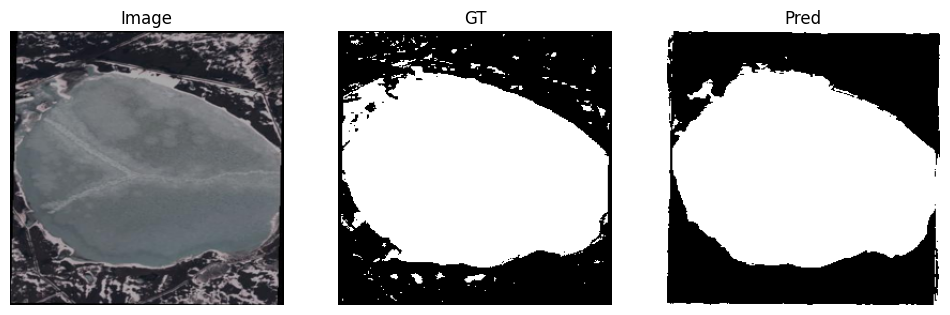

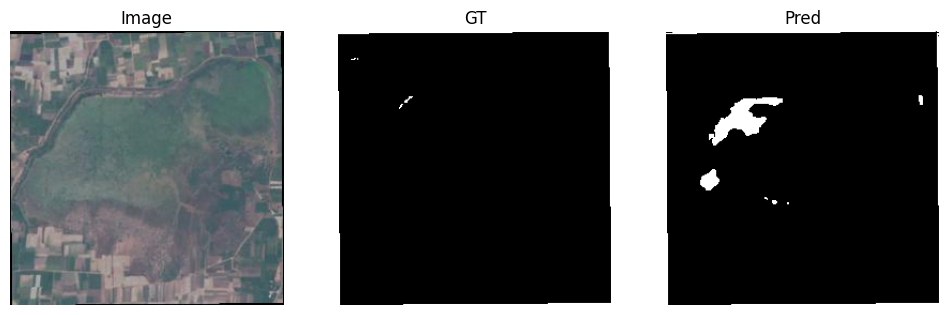

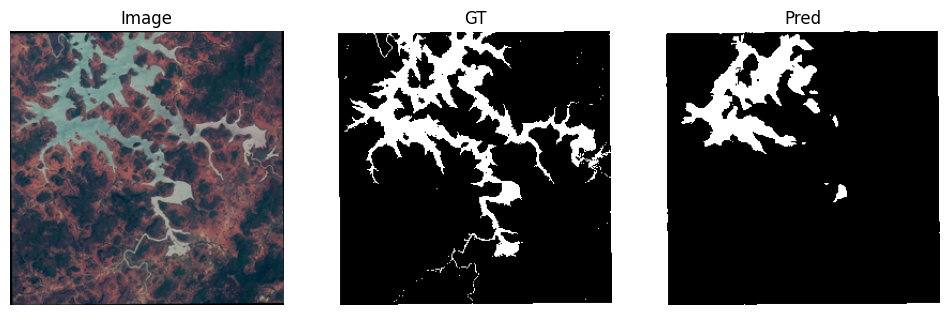

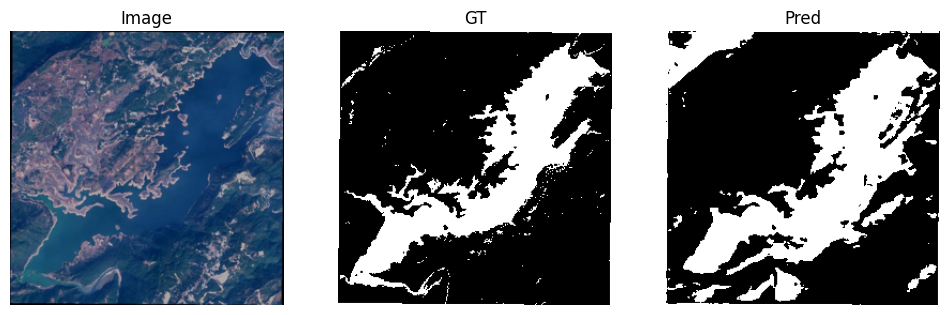

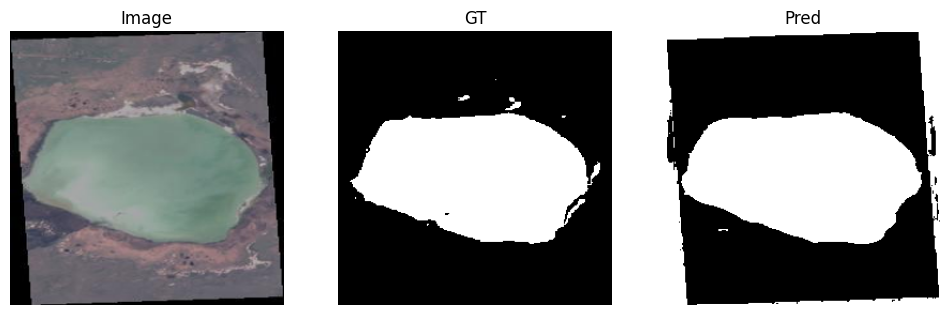

In [5]:
# ---------------------------------------------------------------
# Water-body segmentation with Small-World U-Net
# ---------------------------------------------------------------
import os, glob, random
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
from PIL import Image
import torchvision.transforms as T
import matplotlib.pyplot as plt
from tqdm import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ---------------------------------------------------------------
# Dataset
# ---------------------------------------------------------------
class SatelliteDataset(Dataset):
    def __init__(self, image_dirs, mask_dirs):
        self.image_mask_pairs = []
        for img_dir, mask_dir in zip(image_dirs, mask_dirs):
            for ipath in sorted(glob.glob(os.path.join(img_dir, "*.jpg"))):
                fname = os.path.splitext(os.path.basename(ipath))[0]
                mpath = os.path.join(mask_dir, fname + ".jpg")
                if os.path.exists(mpath):
                    self.image_mask_pairs.append((ipath, mpath))

    def __len__(self): return len(self.image_mask_pairs)

    def __getitem__(self, idx):
        ipath, mpath = self.image_mask_pairs[idx]
        img  = Image.open(ipath).convert("RGB").resize((256,256))
        mask = Image.open(mpath).convert("L" ).resize((256,256), Image.NEAREST)
        img  = T.ToTensor()(img)
        mask = (T.ToTensor()(mask) > 0.5).float()
        return img, mask

# ---------------------------------------------------------------
# Model components
# ---------------------------------------------------------------
class DenseLayer(nn.Module):
    def __init__(self, in_ch, growth):
        super().__init__()
        self.norm = nn.BatchNorm2d(in_ch)
        self.conv = nn.Conv2d(in_ch, growth, 3, padding=1, bias=False)
    def forward(self, x):
        y = self.conv(F.relu(self.norm(x), inplace=True))
        return torch.cat([x, y], 1)

class DenseBlock(nn.Module):
    def __init__(self, in_ch, growth, n_layers=4):
        super().__init__()
        layers, ch = [], in_ch
        for _ in range(n_layers):
            layers.append(DenseLayer(ch, growth))
            ch += growth
        self.block = nn.Sequential(*layers)
        self._out_channels = ch
    @property
    def out_channels(self): return self._out_channels
    def forward(self, x): return self.block(x)

class TransitionDown(nn.Module):
    def __init__(self, ch):
        super().__init__()
        self.td = nn.Sequential(
            nn.BatchNorm2d(ch),
            nn.Conv2d(ch, ch, 1, bias=False),
            nn.MaxPool2d(2)
        )
    def forward(self, x): return self.td(x)

class TransitionUp(nn.Module):
    def __init__(self, in_ch):
        super().__init__()
        self.conv1 = nn.Conv2d(in_ch, in_ch//2, 1, bias=False)
    def forward(self, x):
        x = F.interpolate(x, scale_factor=2, mode="bilinear", align_corners=False)
        return self.conv1(x)

class FeatureAligner(nn.Module):
    def __init__(self):
        super().__init__()
        self.adjust = nn.ModuleDict()
    def forward(self, key, feat, target_hw, target_c):
        if feat.shape[-2:] != target_hw:
            feat = F.interpolate(feat, size=target_hw,
                                 mode="bilinear", align_corners=False)
        if feat.shape[1] != target_c:
            if key not in self.adjust:
                self.adjust[key] = (
                    nn.Conv2d(feat.shape[1], target_c, 1, bias=False)
                    .to(feat.device)
                )
            feat = self.adjust[key](feat)
        return feat

# ---------------------------------------------------------------
# Small-World U-Net (Fixed Version) - MODIFIED: Deterministic connections only
# ---------------------------------------------------------------
class SWUNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=1,
                 base_feats=48, growth=16, depth=4,
                 n_layers=4):  # Removed probabilistic parameters
        super().__init__()
        self.depth = depth
        self.align = FeatureAligner()
        self.first = nn.Conv2d(in_channels, base_feats, 3, padding=1)

        # ---- encoder ----
        enc_blocks, td_layers, enc_out = [], [], []
        ch = base_feats
        for i in range(depth):
            db = DenseBlock(ch, growth, n_layers)
            ch = db.out_channels
            enc_blocks.append(db)
            td_layers.append(TransitionDown(ch))
            enc_out.append(ch)

        # ---- bottleneck ----
        bottleneck = DenseBlock(ch, growth, n_layers)
        bottleneck_in = bottleneck.block[0].conv.in_channels
        ch = bottleneck.out_channels

        # ---- decoder (Fixed) ----
        tu_layers, dec_blocks, dec_in = [], [], []
        for idx in reversed(range(depth)):
            tu = TransitionUp(ch)
            ch_out = ch // 2
            db = DenseBlock(ch_out, growth, n_layers)
            tu_layers.append(tu)
            dec_blocks.append(db)
            dec_in.append(ch_out)
            ch = db.out_channels

        self.final_conv = nn.Conv2d(ch, out_channels, 1)

        # register modules
        self.enc_blocks = nn.ModuleList(enc_blocks)
        self.td_layers  = nn.ModuleList(td_layers)
        self.bottleneck = bottleneck
        self.tu_layers  = nn.ModuleList(tu_layers)
        self.dec_blocks = nn.ModuleList(dec_blocks)  # Keep in original order

        # ---- channel bookkeeping (Fixed) ----
        enc_in = [b.block[0].conv.in_channels for b in self.enc_blocks]
        self.node_in_ch = enc_in + [bottleneck_in] + dec_in
        n_nodes = len(self.node_in_ch)

        # ===== MODIFIED: Deterministic base connections =====
        self.edges = self._get_deterministic_edges(depth, n_nodes)

    def _get_deterministic_edges(self, depth, n_nodes):
        # Create deterministic edge mapping
        emap = {i: [] for i in range(n_nodes)}
        
        # Sequential connections (current <- previous)
        for i in range(1, n_nodes):
            emap[i].append(i-1)
        
        # Skip connections (decoder <- encoder symmetry)
        for i in range(depth):
            # Encoder node i connects to decoder node at same level
            decoder_idx = depth + 1 + (depth - 1 - i)
            emap[decoder_idx].append(i)
            
        return emap

    # ---------------- forward (Fixed) ----------------
    def forward(self, x):
        feats = []
        
        # Encoder path
        out = self.first(x)
        out = self.enc_blocks[0](out)
        feats.append(out)
        prev = self.td_layers[0](out)

        # Encoder nodes 1 to depth-1
        for i in range(1, self.depth):
            dc, dhw = self.node_in_ch[i], prev.shape[-2:]
            agg_list = [self.align(f"seq{i}", prev, dhw, dc)]
            
            for s in self.edges[i]:
                src_feat = feats[s]
                aligned = self.align(f"{s}->{i}", src_feat, dhw, dc)
                agg_list.append(aligned)
                
            aggregated = torch.stack(agg_list).mean(0)
            out = self.enc_blocks[i](aggregated)
            feats.append(out)
            prev = self.td_layers[i](out)

        # Bottleneck node
        idx = self.depth
        dc, dhw = self.node_in_ch[idx], prev.shape[-2:]
        agg_list = [self.align("seqB", prev, dhw, dc)]
        
        for s in self.edges[idx]:
            src_feat = feats[s]
            aligned = self.align(f"{s}->{idx}", src_feat, dhw, dc)
            agg_list.append(aligned)
            
        aggregated = torch.stack(agg_list).mean(0)
        out = self.bottleneck(aggregated)
        feats.append(out)
        prev = out

        # Decoder path
        for d_i in range(self.depth):
            node_idx = self.depth + 1 + d_i
            
            # Transition Up
            up = self.tu_layers[d_i](prev)
            
            # Get target dimensions
            target_hw = up.shape[-2:]
            target_c = self.node_in_ch[node_idx]
            
            # Aggregate features
            agg_list = [self.align(f"seq{node_idx}", up, target_hw, target_c)]
            
            for s in self.edges[node_idx]:
                src_feat = feats[s]
                aligned = self.align(f"{s}->{node_idx}", src_feat, target_hw, target_c)
                agg_list.append(aligned)
                
            aggregated = torch.stack(agg_list).mean(0)
            
            # Process through decoder block
            out = self.dec_blocks[d_i](aggregated)
            feats.append(out)
            prev = out

        # Final convolution
        out = self.final_conv(out)
        return out

# ---------------------------------------------------------------
# Metrics
# ---------------------------------------------------------------
def dice_coefficient(pred, target, eps=1e-6):
    pred, target = pred.view(-1), target.view(-1)
    inter = (pred*target).sum()
    return (2*inter+eps)/(pred.sum()+target.sum()+eps)
def iou_score(pred, target, eps=1e-6):
    pred, target = pred.view(-1), target.view(-1)
    inter = (pred*target).sum()
    return (inter+eps)/(pred.sum()+target.sum()-inter+eps)

# ---------------------------------------------------------------
# Train / evaluate
# ---------------------------------------------------------------
def train_model(image_dirs, mask_dirs):
    ds = SatelliteDataset(image_dirs, mask_dirs)
    assert len(ds)==2841, f"Dataset size mismatch: {len(ds)}"
    tr,val,te = random_split(ds, [1989,568,2841-1989-568])
    tr_ld = DataLoader(tr, 4, shuffle=True,  num_workers=0, pin_memory=True)
    vl_ld = DataLoader(val,4, shuffle=False, num_workers=0)
    te_ld = DataLoader(te, 4, shuffle=False, num_workers=0)
    net = SWUNet().to(device)
    opt = torch.optim.Adam(net.parameters(), lr=1e-4)
    crit= nn.BCEWithLogitsLoss()

    best, wait, patience = 0,0,3
    for ep in range(15):
        # train
        net.train(); tl=td=0
        for x,y in tqdm(tr_ld, desc=f"Epoch {ep+1}"):
            x,y=x.to(device),y.to(device)
            log = net(x); loss=crit(log,y)
            opt.zero_grad(); loss.backward(); opt.step()
            tl += loss.item()
            td += dice_coefficient((torch.sigmoid(log)>0.5).float(), y).item()
        td/=len(tr_ld)

        # val
        net.eval(); vd=0
        with torch.no_grad():
            for x,y in vl_ld:
                x,y=x.to(device),y.to(device)
                p = (torch.sigmoid(net(x))>0.5).float()
                vd += dice_coefficient(p,y).item()
        vd/=len(vl_ld)
        print(f"E{ep+1}: train DICE {td:.4f} | val DICE {vd:.4f}")
        if vd>best: best,wait=vd,0; torch.save(net.state_dict(),"best.pth")
        else:
            wait+=1
            if wait>=patience: break

    net.load_state_dict(torch.load("best.pth"))
    # test
    net.eval(); d=i=0
    with torch.no_grad():
        for x,y in te_ld:
            x,y=x.to(device),y.to(device)
            p=(torch.sigmoid(net(x))>0.5).float()
            d+=dice_coefficient(p,y).item()
            i+=iou_score(p,y).item()
    n=len(te_ld)
    print(f"Test Dice {d/n:.4f} | IoU {i/n:.4f}")
    return net,val,te

# ---------------------------------------------------------------
# Visualisation
# ---------------------------------------------------------------
def visualize(net,dset,n=3):
    net.eval()
    for k in range(min(n,len(dset))):
        img,msk=dset[k]
        with torch.no_grad():
            p=(torch.sigmoid(net(img.unsqueeze(0).to(device))).squeeze().cpu()>0.5).numpy()
        fig,ax=plt.subplots(1,3,figsize=(12,4))
        ax[0].imshow(img.permute(1,2,0)); ax[0].set_title("Image")
        ax[1].imshow(msk.squeeze(),cmap='gray'); ax[1].set_title("GT")
        ax[2].imshow(p,cmap='gray'); ax[2].set_title("Pred")
        for a in ax: a.axis("off")
        plt.show()

# ---------------------------------------------------------------
# Entry-point
# ---------------------------------------------------------------
if __name__=="__main__":
    base="/kaggle/input/water-bodies-segmentation-dataset-with-split/Water_Bodies_Dataset_Split"
    img_dirs =[os.path.join(base,"train_images"),os.path.join(base,"valid_images")]
    msk_dirs =[os.path.join(base,"train_masks"),os.path.join(base,"valid_masks")]

    net,val_set,test_set = train_model(img_dirs,msk_dirs)
    visualize(net,val_set,3)
    visualize(net,test_set,2)